Quasi-binomial regression

This notebook demonstrates using custom variance functions and non-binary data
with the quasi-binomial GLM family to perform a regression analysis using
a dependent variable that is a proportion.

The notebook uses the barley leaf blotch data that has been discussed in
several textbooks. See below for one reference:

https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_glimmix_sect016.htm

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

The raw data, expressed as percentages.  We will divide by 100
to obtain proportions.

In [2]:
raw = StringIO("""0.05,0.00,1.25,2.50,5.50,1.00,5.00,5.00,17.50
0.00,0.05,1.25,0.50,1.00,5.00,0.10,10.00,25.00
0.00,0.05,2.50,0.01,6.00,5.00,5.00,5.00,42.50
0.10,0.30,16.60,3.00,1.10,5.00,5.00,5.00,50.00
0.25,0.75,2.50,2.50,2.50,5.00,50.00,25.00,37.50
0.05,0.30,2.50,0.01,8.00,5.00,10.00,75.00,95.00
0.50,3.00,0.00,25.00,16.50,10.00,50.00,50.00,62.50
1.30,7.50,20.00,55.00,29.50,5.00,25.00,75.00,95.00
1.50,1.00,37.50,5.00,20.00,50.00,50.00,75.00,95.00
1.50,12.70,26.25,40.00,43.50,75.00,75.00,75.00,95.00""")

The regression model is a two-way additive model with
site and variety effects.  The data are a full unreplicated
design with 10 rows (sites) and 9 columns (varieties).

In [3]:
df = pd.read_csv(raw, header=None)
df = df.melt()
df["site"] = 1 + np.floor(df.index / 10).astype(np.int)
df["variety"] = 1 + (df.index % 10)
df = df.rename(columns={"value": "blotch"})
df = df.drop("variable", axis=1)
df["blotch"] /= 100

Fit the quasi-binomial regression with the standard variance
function.

In [4]:
model1 = sm.GLM.from_formula("blotch ~ 0 + C(variety) + C(site)",
          family=sm.families.Binomial(), data=df)
result1 = model1.fit(scale="X2")

The plot below shows that the default variance function is
not capturing the variance structure very well. Also note
that the scale parameter estimate is quite small.

Text(0, 0.5, 'Residual')

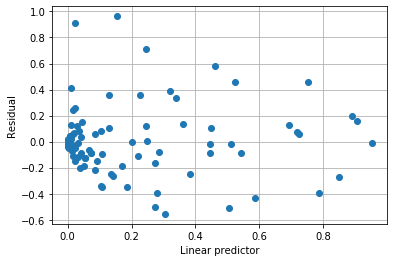

In [5]:
plt.clf()
plt.grid(True)
plt.plot(result1.fittedvalues, result1.resid_pearson, 'o')
plt.xlabel("Linear predictor")
plt.ylabel("Residual")

An alternative variance function is mu^2 * (1 - mu)^2.

In [6]:
class vf(sm.families.varfuncs.VarianceFunction):
    def __call__(self, mu):
        return np.clip(mu**2 * (1 - mu)**2, 0.0001, 0.9999)

    def deriv(self, mu):
        return 2*mu - 6*mu**2 + 4*mu**3

Fit the quasi-binomial regression with the alternative variance
function.

In [7]:
bin = sm.families.Binomial()
bin.variance = vf()
model2 = sm.GLM.from_formula("blotch ~ 0 + C(variety) + C(site)", family=bin, data=df)
result2 = model2.fit(scale="X2")

With the alternative variance function, the mean/variance relationship
seems to capture the data well, and the estimated scale parameter is
close to 1.

Text(0, 0.5, 'Residual')

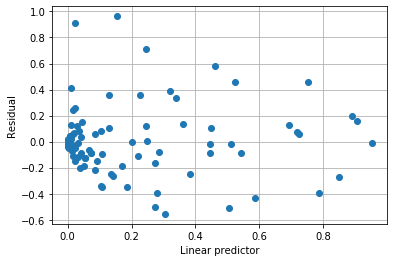

In [8]:
plt.clf()
plt.grid(True)
plt.plot(result1.fittedvalues, result1.resid_pearson, 'o')
plt.xlabel("Linear predictor")
plt.ylabel("Residual")